# 3. Partial alignment of Spateo for 2D slices
In sectioning experiments, two slices may only partially overlap along the z-axis due to differences in array placement on the tissue or other processing steps. As a result, only a portion of each slice needs to be aligned. In this tutorial, we will learn how to align slices with partially overlapping regions using Spateo.

In [22]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Running this notebook on: ", device)

import spateo as st
print("Last run with spateo version:", st.__version__)

# Other imports
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
import numpy as np

# Uncomment the following if running on the server
import pyvista as pv
pv.start_xvfb()

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

Running this notebook on:  cuda
Last run with spateo version: 1.1.0.dev30+084c763.dirty
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(EE) 
Fatal server error:
(EE) Server is already active for display 99
	If this server is no longer running, remove /tmp/.X99-lock
	and start again.
(EE) 


## Load the data
In this tutorial, we will first demonstrate how Spateo performs partial alignment on Drosophila data obtained using the Stereo-Seq technique. Due to experimental processing and other factors, some regions of the slice are missing. Using Spateo's alignment, we can robustly align them.

Next, to understand how each parameter influences partial alignment, we then generate pseudo-slices and apply different overlap ratio to them. For this demonstration, we use slices from the adult mouse central nervous system, obtained using the STARMap Plus technique. According to the STARMap Plus protocol, each slice has a three-dimensional volume, where the z-axis scale is much smaller than the x and y axes. This allows us to generate pseudo-slices with aligned spatial coordinates. You can download the processed data from the links below. After downloading, be sure to place the data in the appropriate directory.

- [Drosophila E9-10h slice #6](https://drive.google.com/file/d/1exjx5NXzLZIX6_iPysZAKAnOsud4cv9r/view?usp=drive_link)
- [Drosophila E9-10h slice #7](https://drive.google.com/file/d/1eupNXtMlQugq643ofs6DTPL2cnY4UVNx/view?usp=drive_link)
- [Adult mouse central nervous system from STARMap Plus dataset sagittal #3](https://drive.google.com/file/d/1fBHNb80M9yutS2EvXaJMuRQqmvK-rRr5/view?usp=drive_link)

In [2]:
# Load the slices
slice1 = st.read('./data/Drosophila_E9-10h_slice_6.h5ad')
slice2 = st.read('./data/Drosophila_E9-10h_slice_7.h5ad')

slice1, slice2

(AnnData object with n_obs × n_vars = 1417 × 8484
     obs: 'anno_tissue'
     obsm: 'spatial'
     varm: 'vel_params'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 1438 × 8484
     obs: 'anno_tissue'
     obsm: 'spatial'
     varm: 'vel_params'
     layers: 'counts')

The data has already preprocessed so you don't need to do operations like normalization.

We can visualize the slices before alignment, where it is evident that these two slices partially overlap with a rotation.

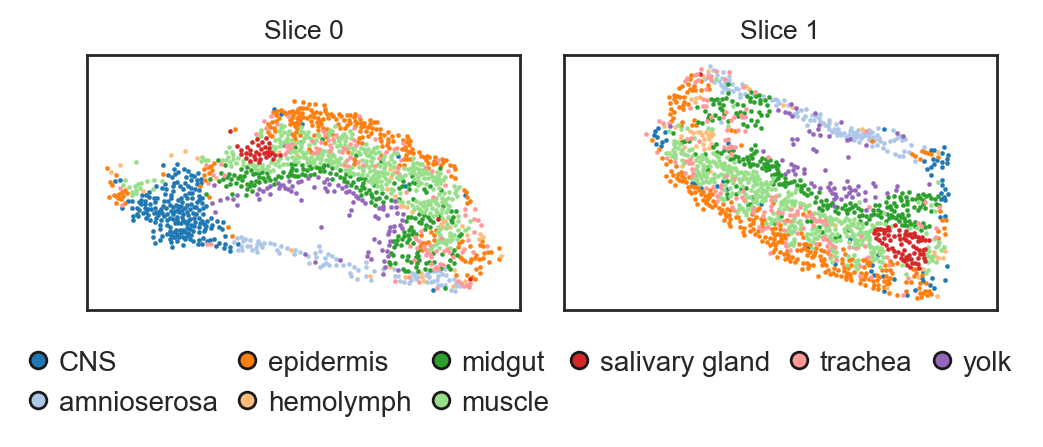

In [3]:
spatial_key = 'spatial'
cluster_key = 'anno_tissue'

st.pl.slices_2d(
    slices = [slice1, slice2],
    label_key = cluster_key,
    spatial_key = spatial_key,
    height=2,
    center_coordinate=True,
    show_legend=True,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.5, 0) ,'ncol': 6, 'borderaxespad': -2, 'frameon': False},
)

Here, we can easily align them using `st.align.morpho_align`.

In [23]:
key_added = 'align_spatial'
st.align.group_pca([slice1, slice2], pca_key='X_pca')
aligned_slices, pis = st.align.morpho_align(
    models=[slice1, slice2],
    spatial_key=spatial_key,
    key_added=key_added,
    device=device,
    verbose=True,
    rep_layer='X_pca',
    rep_field='obsm',
    dissimilarity='cos',
    max_iter=500,
)

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%|-----> Filtered all samples for common genes. There are 8484 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([246.0567, 246.0567])...
|-----------> Scale: tensor([[379.6770, 292.3748],
        [544.1337, 267.8460]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [2.0199s]
|-----> Key Parameters: gamma: 0.744434654712677; sigma2: 0.0010041953064501286; probability_parameters: [tensor(0.0213, device='cuda:0')]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [0.0090s]


After alignment, we can examine the overlay of the two slices. It looks that the slices are perfectly aligned. Here we show the rigid alignment results

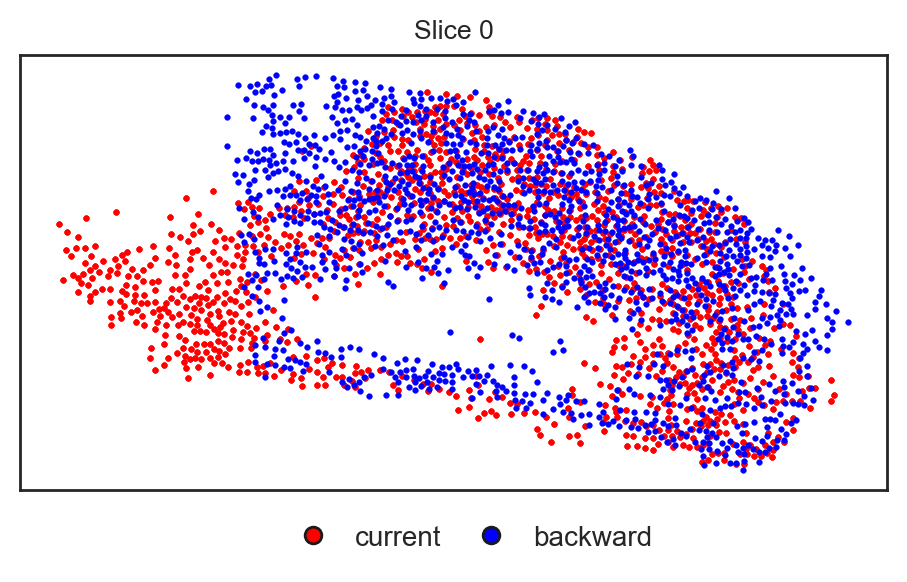

In [24]:
st.pl.overlay_slices_2d(slices = aligned_slices, spatial_key = key_added, height=3, overlay_type='backward', legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.5, 0),'borderaxespad': -2, 'frameon': False},)

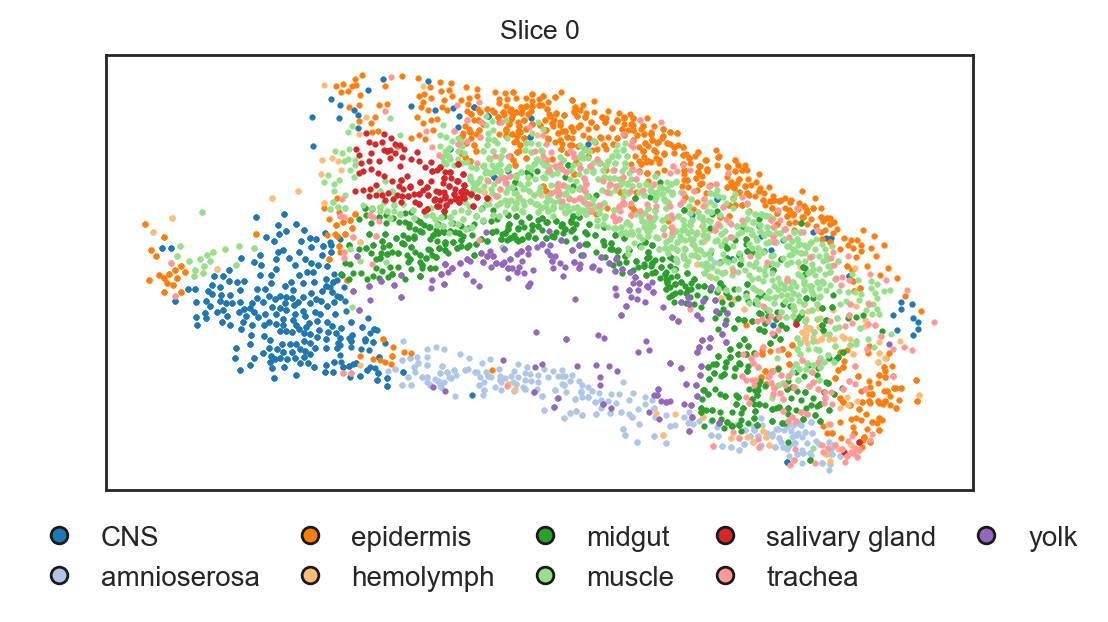

In [25]:
st.pl.overlay_slices_2d(slices = aligned_slices, spatial_key = key_added, label_key=cluster_key, height=3, overlay_type='backward', legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.5, 0),'borderaxespad': -2, 'frameon': False, 'ncol': 5},)

Let's visualize the optimization process to see how the two slices align step by step. This can help us understand how Spateo iteratively refines the alignment from the initial state to the final well-aligned state

In [26]:
st.pl.optimization_animation(
    aligned_slices = aligned_slices,
    spatial_key=spatial_key,
    key_added=key_added,
    iter_key_added = "iter_spatial",
    filename = "./results/optimization_animate_partial",
    fps = 10,
    stepsize = 10,
    label_key=cluster_key,
)

<img src="./results/optimization_animate_partial.gif" alt="Alt Text" width="800" height="500">

## Explore the partial alignment related parameters: partial_robust_level, nn_init, as well as nonrigid alignment parameters

If you want to explore the parameters influencing partial alignment in more depth, continue with the following section. Generally, the key parameters affecting partial alignment are as follows: `partial_robust_level`, `nn_init`, and the nonrigid alignment parameters (see [Nonrigid alignment](./2.%20Nonrigid%20alignment%20of%20Spateo%20for%202D%20slices.ipynb)). To this end, we will use the STARMap Plus data and manually clip the slices so the slices are partially overlapped.

In [23]:
# Load the STARMap Plus slice
adata = st.read('./data/sagittal3.h5ad')

print(adata)
print(adata.obsm['spatial_raw'].shape)

AnnData object with n_obs × n_vars = 207591 × 1022
    obs: 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type', 'n_genes'
    var: 'n_cells'
    uns: 'Main_molecular_tissue_region_palette', 'log1p', 'pca'
    obsm: 'X_pca', 'spatial', 'spatial_raw'
    varm: 'PCs'
    layers: 'counts'
(207591, 3)


## Visualize the STARMap Plus slice in 3D

<div class="alert alert-warning">
<strong>Warning:</strong>

The following code block involves [PyVista](https://docs.pyvista.org/) visualization. Before running the PyVista-based visualization function `st.pl.three_d_plot`, please ensure that PyVista is installed correctly, especially for server configurations. Incorrect installation may cause Jupyter Notebook to crash. There are certain specifications to consider when running PyVista on a remote server. We recommend reviewing their [tutorials](https://docs.pyvista.org/user-guide/jupyter/trame.html#remote-jupyter-host), particularly for remote Jupyter environments.
    
</div>

As the STARMap Plus slice has a three-dimensional volume, we can perform pseudo-sectioning on it. The slice is visualized in 3D space below. If you prefer not to display the visualization, you can skip this step.

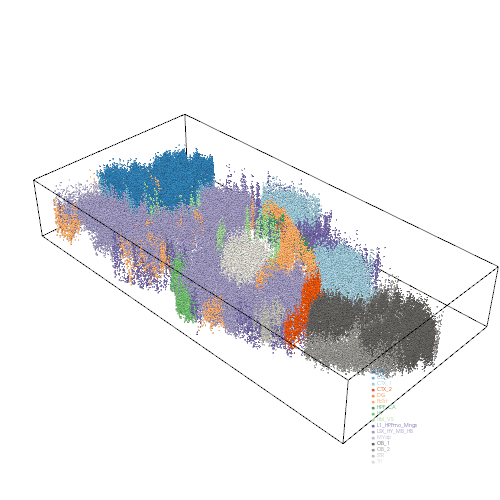

In [24]:
point_cloud, _ = st.tdr.construct_pc(adata=adata,spatial_key="spatial_raw",groupby="Main_molecular_tissue_region",key_added="tissue",colormap='tab20c',)

# make the z height bigger
point_cloud.points[:,2] *= 500

# show the STARMap Plus slice in 3D
st.pl.three_d_plot(
    model=point_cloud,
    key="tissue",
    model_style='points',
    model_size=2,
    jupyter="static",
    window_size=(500, 500),
    show_outline=True,
    outline_kwargs={'show_labels': False, 'outline_width': 1},
)

## Cut along z-axis to generate pseudo slices

Next, we cut the STARMap Plus slice along the z-axis to generate four pseudo-slices. It's important to note that this strategy for generating pseudo-slices is not equivalent to random sampling, as the spatial distribution of the STARMap Plus slice along the z-axis will also vary.

In [3]:
slices = st.align.split_slice(adata=adata,spatial_key='spatial_raw',split_num=4,axis=2,)
slices[:2]

[AnnData object with n_obs × n_vars = 51897 × 1022
     obs: 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type', 'n_genes', 'slice'
     var: 'n_cells'
     uns: 'Main_molecular_tissue_region_palette', 'log1p', 'pca'
     obsm: 'X_pca', 'spatial', 'spatial_raw'
     varm: 'PCs'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 51897 × 1022
     obs: 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type', 'n_genes', 'slice'
     var: 'n_cells'
     uns: 'Main_molecular_tissue_region_palette', 'log1p', 'pca'
     obsm: 'X_pca', 'spatial', 'spatial_raw'
     varm: 'PCs'
     layers: 'counts']

Despite having the same number of cells, the spatial distribution varies significantly from section to section, as shown below

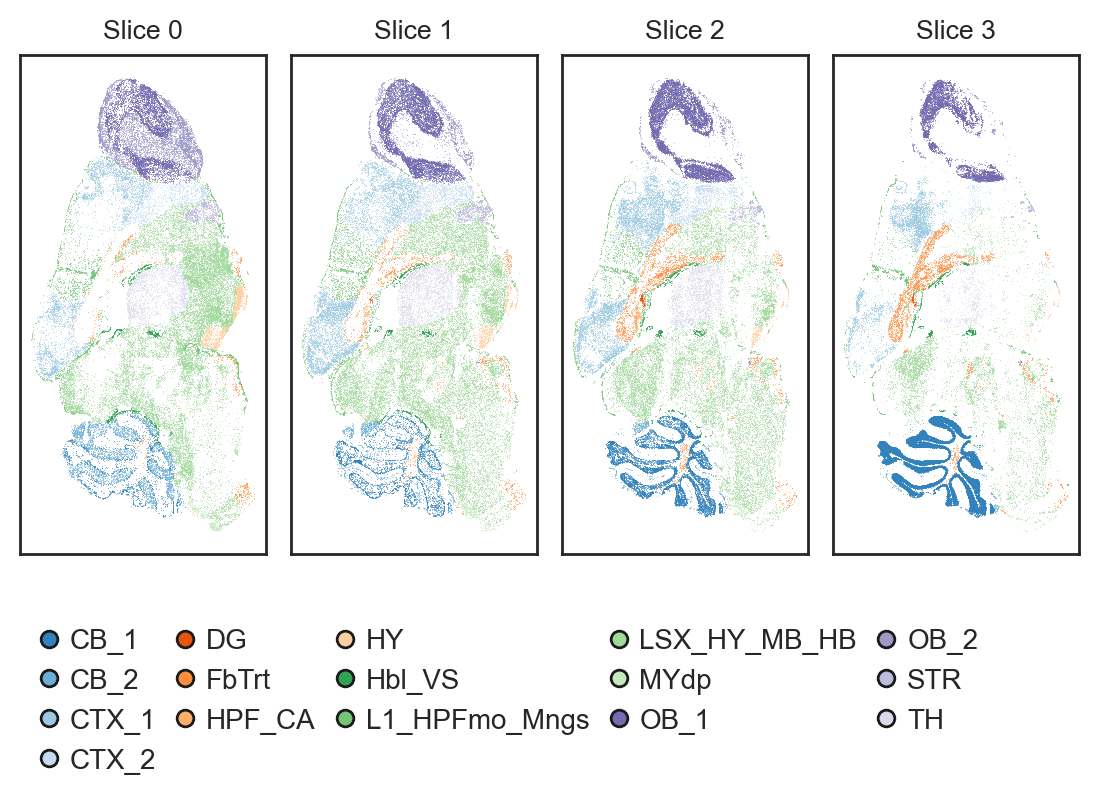

In [4]:
spatial_key = 'spatial_raw'
cluster_key = 'Main_molecular_tissue_region'

st.pl.slices_2d(
    slices = slices,
    label_key = cluster_key,
    spatial_key = spatial_key,
    height=4,
    center_coordinate=False,
    show_legend=True,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.49, 0) ,'ncol': 5, 'borderaxespad': -4, 'frameon': False},
    cmap='tab20c',
)

## Crop slices for partially overlaps

To simulate partial overlaps, we dirrectly crop the slice along x- or y-axis. You can control the overlap ratio using `overlay_ratio` parameter. 

In [5]:
def crop_slices(
    slice1,
    slice2,
    spatial_key,
    overlay_ratio,
    axis=1,
):
    y_max, y_min = np.max(slice1.obsm[spatial_key][:,1]), np.min(slice1.obsm[spatial_key][:,1])
    x_max, x_min = np.max(slice1.obsm[spatial_key][:,0]), np.min(slice1.obsm[spatial_key][:,0])
    if axis == 0:
        slice_1_low = (1-overlay_ratio)*(x_max-x_min) / (2-overlay_ratio) + x_min
        slice_2_high = x_max - (1-overlay_ratio)*(x_max-x_min) / (2-overlay_ratio)
    elif axis == 1:
        slice_1_low = (1-overlay_ratio)*(y_max-y_min) / (2-overlay_ratio) + y_min
        slice_2_high = y_max - (1-overlay_ratio)*(y_max-y_min) / (2-overlay_ratio)
    slice1_crop = slice1[slice1.obsm[spatial_key][:,axis] > slice_1_low,:].copy()
    slice2_crop = slice2[slice2.obsm[spatial_key][:,axis] < slice_2_high,:].copy()
    return slice1_crop, slice2_crop

In [17]:
slice1 = slices[1].copy()
slice2 = slices[2].copy()

slice1, slice2 = crop_slices(
    slice1, 
    slice2, 
    spatial_key='spatial', 
    overlay_ratio = 0.2,
)

After cropping, the two slices only overlap for 50% region.

In [21]:
slice1.write_h5ad('./data/sagittal3_partial_1.h5ad')
slice2.write_h5ad('./data/sagittal3_partial_2.h5ad')

In [18]:
st.align.rigid_transformation(slice2, 'spatial', 'spatial')

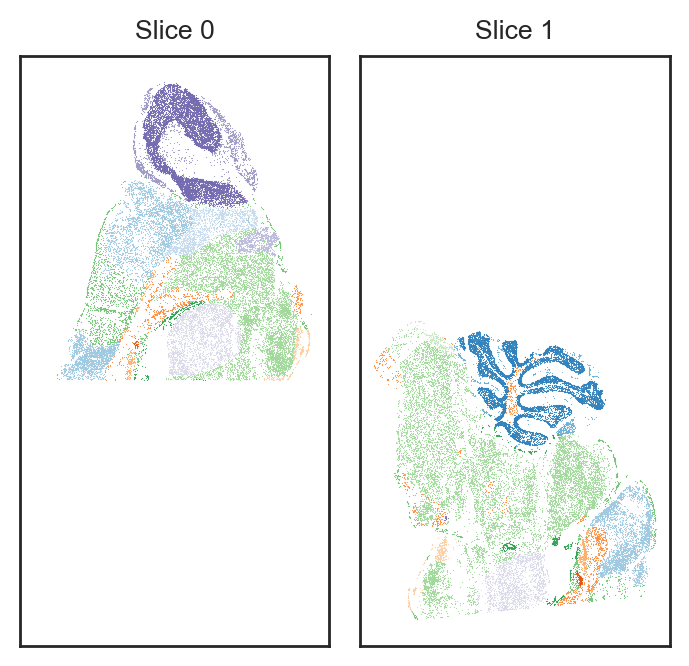

In [19]:
spatial_key = 'spatial'
cluster_key = 'Main_molecular_tissue_region'

st.pl.slices_2d(
    slices = [slice1, slice2],
    label_key = cluster_key,
    spatial_key = spatial_key,
    height=4,
    center_coordinate=False,
    show_legend=False,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.49, 0) ,'ncol': 5, 'borderaxespad': -4, 'frameon': False},
    cmap='tab20c',
)

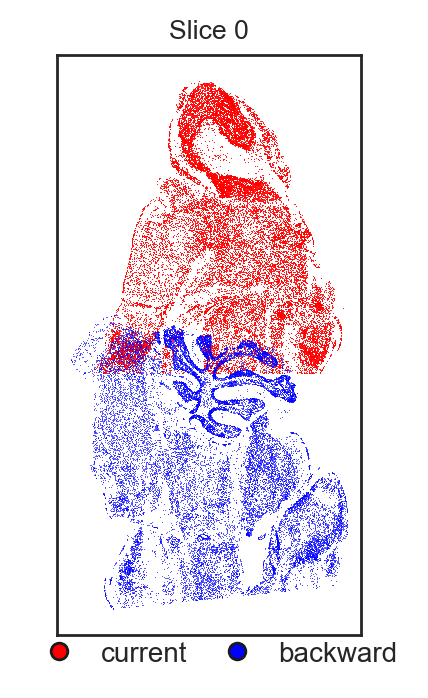

In [20]:
st.pl.overlay_slices_2d(slices = [slice1, slice2], spatial_key = 'spatial', height=4, overlay_type='backward')

Next, we can try adding a random rotation

In [40]:
def rigid_transformation(
    adata, 
    spatial_key, 
    key_added, 
    theta=None,
    inplace=True,
):
    if inplace == False:
        adata = adata.copy()
    spatial = adata.obsm[spatial_key]
    mean = np.mean(spatial, axis=0)
    spatial = spatial - mean
    if theta is None:
        # random rotation
        theta = np.random.rand() * 2 * np.pi
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    spatial = np.matmul(spatial, rotation_matrix)
    spatial = spatial + mean
    adata.obsm[key_added] = spatial
    if inplace:
        pass 
    else:
        return adata

In [41]:
rigid_transformation(
    slice2, 
    'spatial', 
    'spatial', 
    inplace=True
)

In [62]:
slice2

AnnData object with n_obs × n_vars = 34407 × 1022
    obs: 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type', 'n_genes', 'slice'
    var: 'n_cells'
    uns: 'Main_molecular_tissue_region_palette', 'log1p', 'pca'
    obsm: 'X_pca', 'spatial', 'spatial_raw'
    varm: 'PCs'
    layers: 'counts'

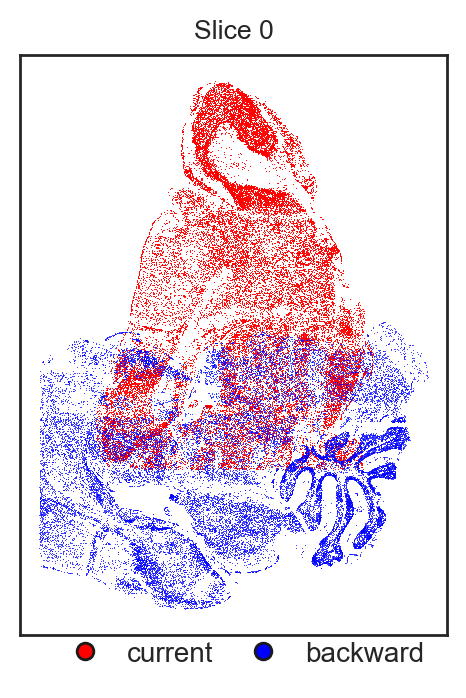

In [42]:
st.pl.overlay_slices_2d(slices = [slice1, slice2], spatial_key = 'spatial', height=4, overlay_type='backward')

## Spateo partial alignment

Next, we use Spateo partial alignment to align these two slices. Please note that we set `partial_robust_level=50` (increasing `partial_robust_level` will make the alignment more robust to the partial overlap, default value is 10). You can also try other parameter settings, which we will investigate later.

In [49]:
key_added = 'align_spatial'
spatial_key = 'spatial'
# spateo return aligned slices as well as the mapping matrix
aligned_slices, pis = st.align.morpho_align(
    models=[slice1, slice2],
    spatial_key=spatial_key,
    key_added=key_added,
    device=device,
    partial_robust_level=50,
    rep_layer=['X_pca'],
    rep_field=['obsm'],
    dissimilarity=['cos'],
)

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([16660.1055, 16660.1055])...
|-----------> Scale: tensor([[19145.3926, 25693.7109],
        [20163.9238, 49613.6914]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [9.1753s]
|-----> Key Parameters: gamma: 0.5054906606674194; sigma2: 0.0010000000474974513; probability_parameters: [tensor(0.0100, device='cuda:0')]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [0.4081s]


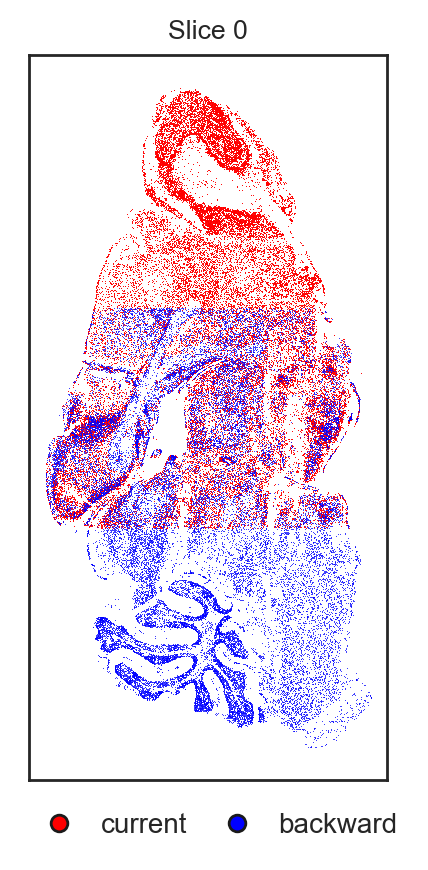

In [50]:
# Visualize the alignment results
st.pl.overlay_slices_2d(slices = aligned_slices, spatial_key = key_added, height=5, overlay_type='backward')

In [54]:
st.pl.optimization_animation(
    aligned_slices = aligned_slices,
    spatial_key=spatial_key,
    key_added=key_added,
    iter_key_added = "iter_spatial",
    filename = "./results/optimization_animate_partial_starmap",
    fps = 10,
    stepsize = 10,
    label_key=cluster_key,
    n_sampling=20000,
)

<img src="./results/optimization_animate_partial_starmap.gif" alt="Alt Text" width="800" height="500">

## Investigate Parameters Settings in Spateo Partial Alignment

Theoretically, three parameters control the performance of partial alignment results in Spateo. We describe each parameter below:

- **partial_robust_level**: [robustness to partial overlap] The scaling factor of the Gaussian distribution when calculating the assignment matrix. A smaller value indicates a larger influence range for each point, which can lead to less robustness for partial overlap. Conversely, a larger value results in a smaller influence range, which could reduce the optimization accuracy.

- **nn_init**: [Perform guiding optimization] If to perform guiding optimization. In general, `nn_init` is always effective as it provides a good initial value, helping the algorithm find an optimal solution without being affected by factors like partial overlap and rotation. So we highly recommend user to enable this.

- **Other nonrigid parameters**: [Flexible of transformation] Other nonrigid transformations parameters can also affect the results of partial alignment. If the transformation is too flexible, the algorithm may distort and incorrectly align the non-overlapping regions.

Next, we show the influence of different parameter settings. As we have the pseudo-slices' ground-truth spatial coordinates, we can directly measure the mean absolute error to validate the results. Here, we iterate through different parameter settings.

In [55]:
import time
partial_robust_level_list = [1, 2, 5, 10, 20, 30, 50, 100, 200]
# iterate all the parameters
aligned_slices = [slice1.copy(), slice2.copy()]
spatial_key = 'spatial'
for partial_robust_level in partial_robust_level_list:
    key_added = f"align_spatial_{partial_robust_level}"
    aligned_slices, pis = st.align.morpho_align(
        models=aligned_slices,
        spatial_key=spatial_key,
        key_added=key_added,
        device=device,
        partial_robust_level=partial_robust_level,
        verbose=False,
        rep_layer='X_pca',
        rep_field='obsm',
        dissimilarity='cos',
    )

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [15.9966s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [14.0719s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [11.6695s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [12.0036s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [13.6816s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [15.9581s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 1

In [57]:
def MAE(
    spatial1,
    spatial2,
    return_err = False,
):
    if len(spatial1.shape) == 3:
        spatial1 = spatial1[:, :2]
    if len(spatial2.shape) == 3:
        spatial2 = spatial2[:, :2]
    ae = np.linalg.norm(spatial1 - spatial2, axis=1)
    mae = np.mean(ae)
    mae_var = np.mean((ae - mae)**2)
    if return_err:
        return mae, mae_var, ae
    else:
        return mae, mae_var

In [64]:
maes = np.zeros((len(partial_robust_level_list), ))
for i, partial_robust_level in enumerate(partial_robust_level_list):
    key_added = f"align_spatial_{partial_robust_level}"
    maes[i], _ = MAE(aligned_slices[1].obsm['spatial_raw'][:,:2], aligned_slices[1].obsm[f'{key_added}'])

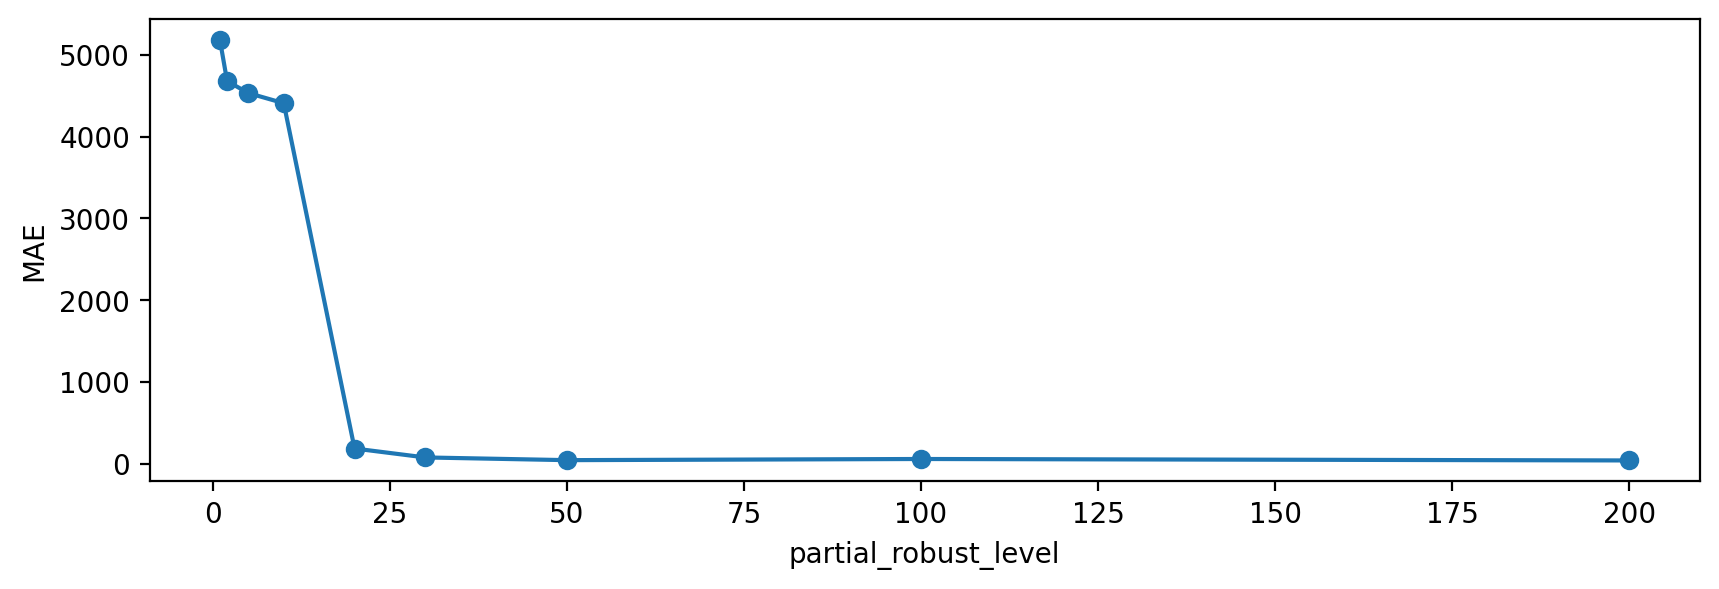

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(partial_robust_level_list, maes, marker='o')
ax.set_xlabel('partial_robust_level')
ax.set_ylabel('MAE')
plt.show()

To see the Spateo's robustness to different overlap ratio, we next use different overlap ratio to generate the data.

In [81]:
overlap_ratio_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
partial_slices_pair = []

for i in range(len(overlap_ratio_list)):
    slice1 = slices[1].copy()
    slice2 = slices[2].copy()
    slice1, slice2 = crop_slices(
        slice1, 
        slice2, 
        spatial_key='spatial', 
        overlay_ratio = overlap_ratio_list[i],
    )
    rigid_transformation(
        slice2, 
        'spatial', 
        'spatial', 
        inplace=True
    )
    partial_slices_pair.append([slice1.copy(), slice2.copy()])

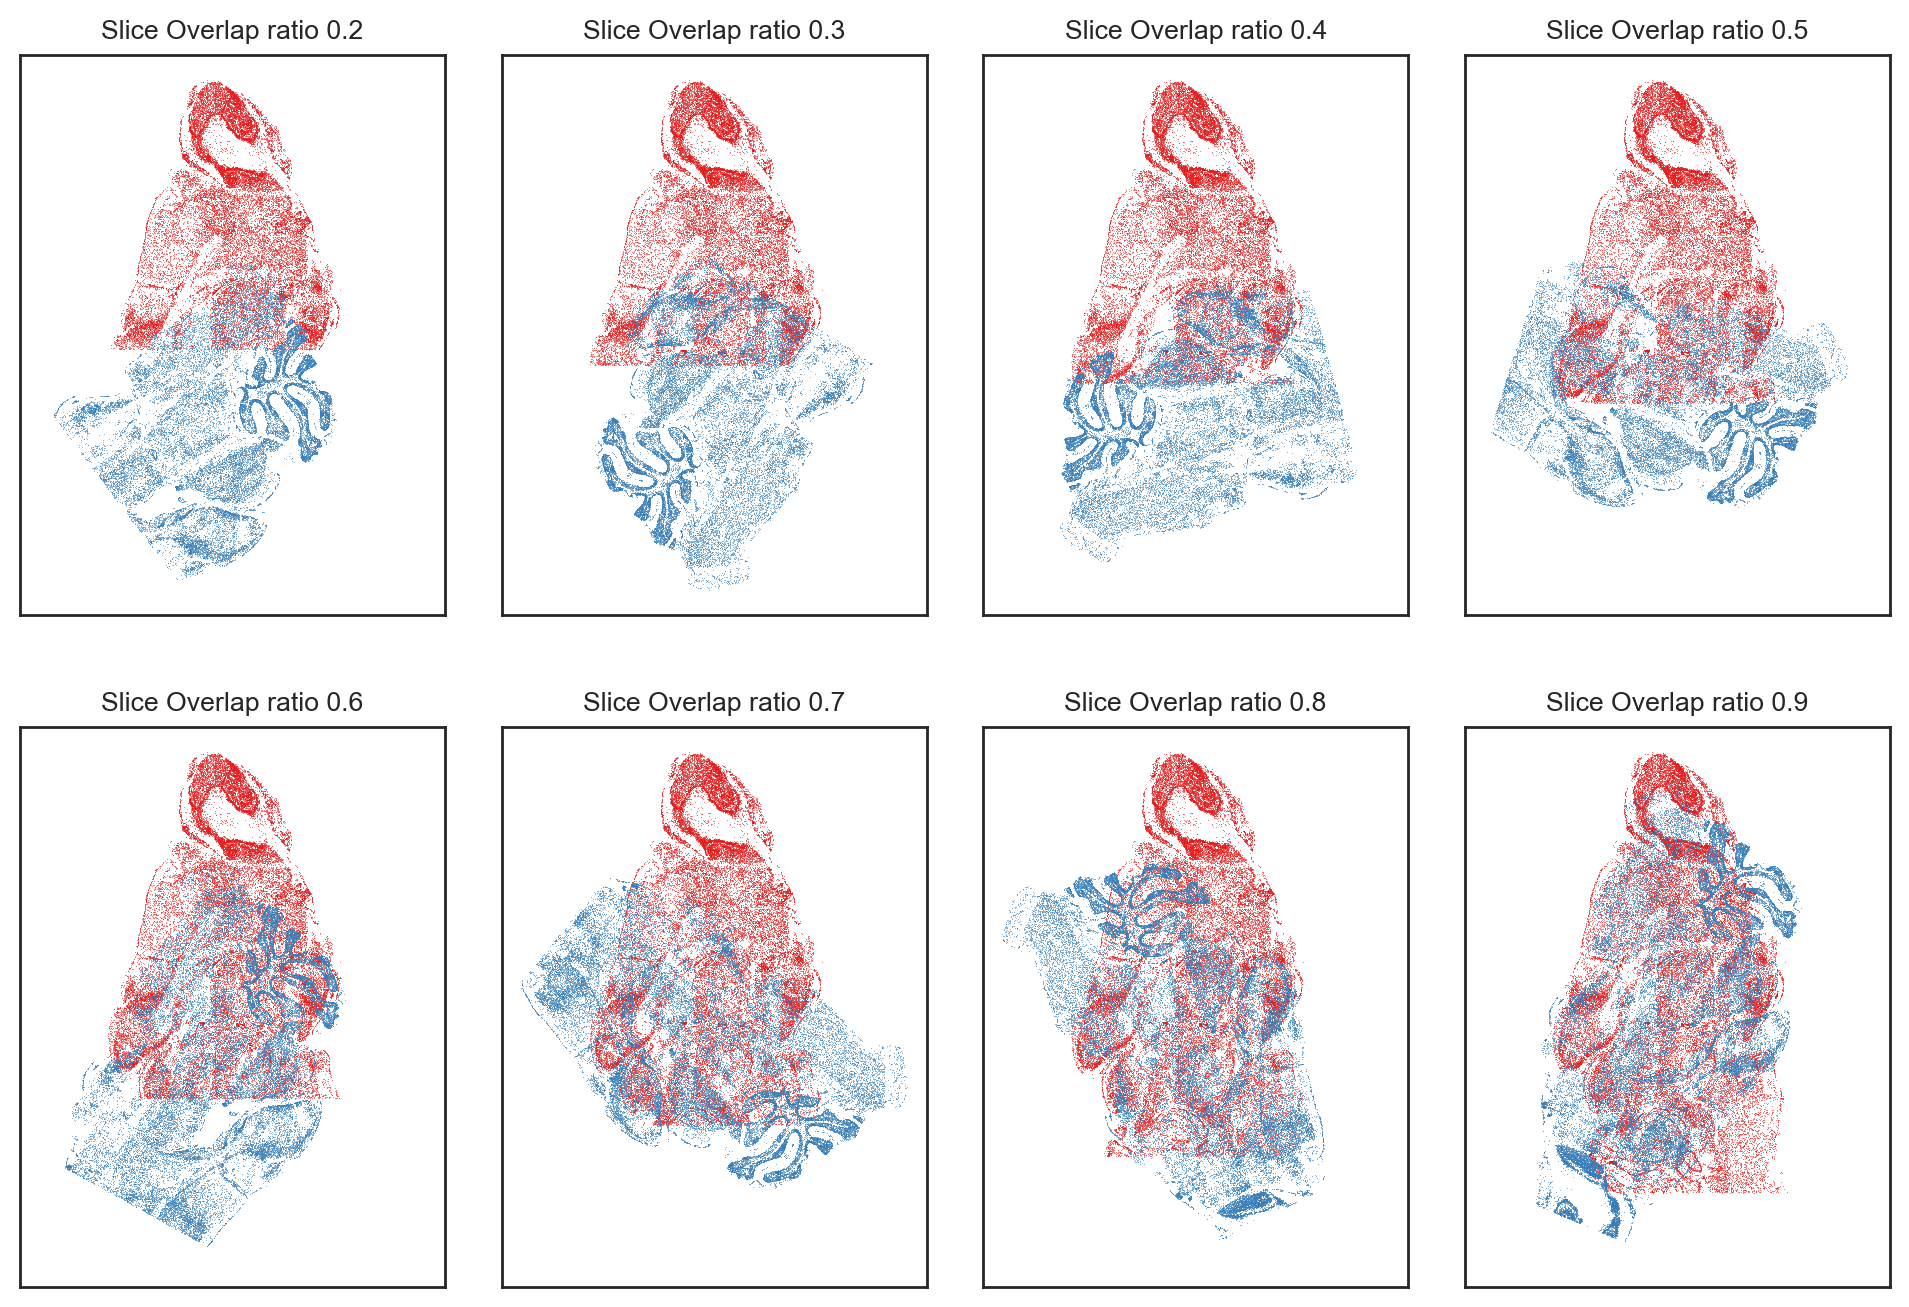

In [82]:
concat_partial_slices = [ad.concat(p_s_p, label='batch') for p_s_p in partial_slices_pair]
for i in range(len(concat_partial_slices)):
    concat_partial_slices[i].obs['overlap_ratio'] = 'Overlap ratio ' + str(overlap_ratio_list[i])
st.pl.slices_2d(
    slices = concat_partial_slices,
    label_key = 'batch',
    spatial_key = 'spatial',
    height=4,
    center_coordinate=False,
    show_legend=False,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.49, 0) ,'ncol': 5, 'borderaxespad': -4, 'frameon': False},
    palette='Set1',
    ncols=4,
    slices_key='overlap_ratio',
)

In [83]:
spatial_key = 'spatial'
key_added = "align_spatial"
aligned_slices_list = []
for i in range(len(overlap_ratio_list)):
    aligned_slices = partial_slices_pair[i]
    aligned_slices, pis = st.align.morpho_align(
        models=aligned_slices,
        spatial_key=spatial_key,
        key_added=key_added,
        device=device,
        partial_robust_level=50,
        verbose=False,
        rep_layer='X_pca',
        rep_field='obsm',
        dissimilarity='cos',
    )
    aligned_slices_list.append(aligned_slices)

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [10.1164s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [10.8682s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [11.9148s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [15.8218s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [17.3275s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [19.1430s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 1

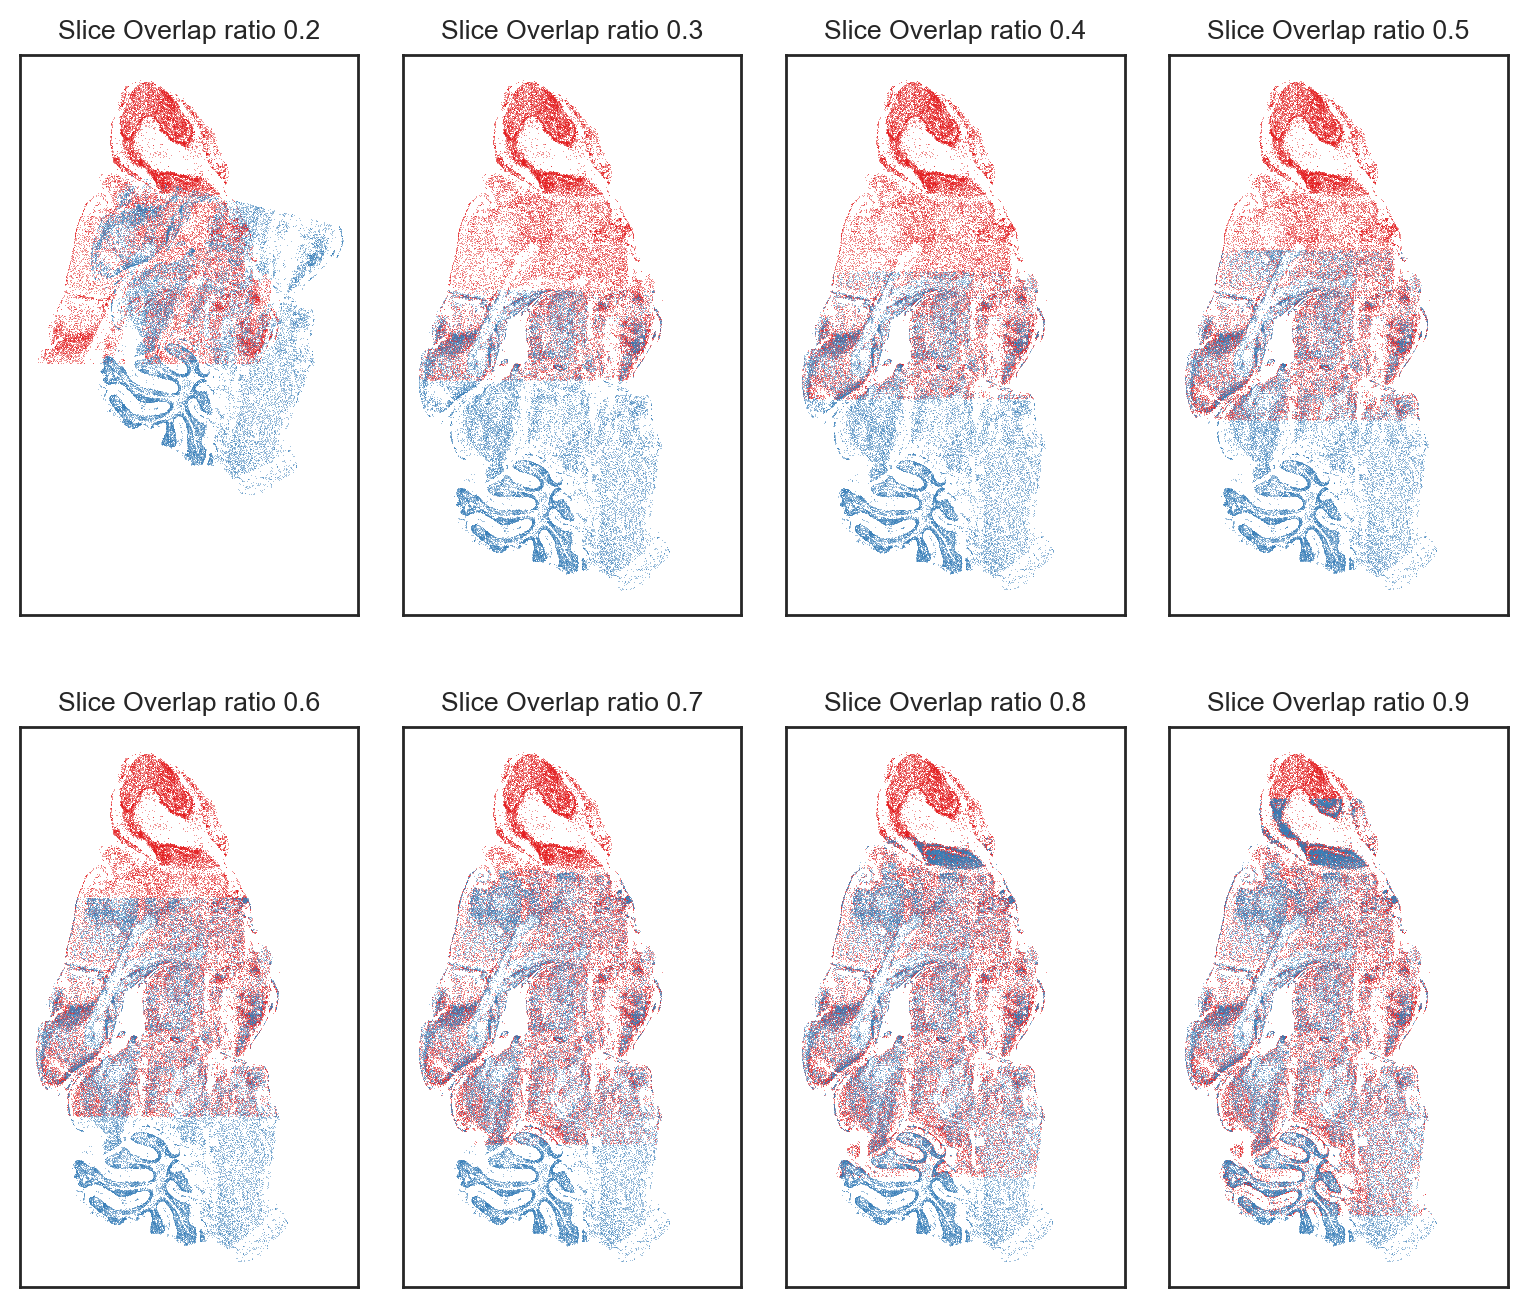

In [84]:
concat_aligned_slices = [ad.concat(a_s, label='batch') for a_s in aligned_slices_list]
for i in range(len(concat_aligned_slices)):
    concat_aligned_slices[i].obs['overlap_ratio'] = 'Overlap ratio ' + str(overlap_ratio_list[i])
st.pl.slices_2d(
    slices = concat_aligned_slices,
    label_key = 'batch',
    spatial_key = key_added,
    height=4,
    center_coordinate=False,
    show_legend=False,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.49, 0) ,'ncol': 5, 'borderaxespad': -4, 'frameon': False},
    palette='Set1',
    ncols=4,
    slices_key='overlap_ratio',
)

Let's try what will happen if we set a very flexible nonrigid transformation

In [71]:
key_added = 'align_spatial'
spatial_key = 'spatial'
# spateo return aligned slices as well as the mapping matrix
aligned_slices, pis = st.align.morpho_align(
    models=[slice1, slice2],
    spatial_key=spatial_key,
    key_added=key_added,
    device=device,
    partial_robust_level=50,
    beta=0.1,
    lambdaVF=10,
    max_iter=500,
    rep_layer=['X_pca'],
    rep_field=['obsm'],
    dissimilarity=['cos'],
)

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([16660.1055, 16660.1055])...
|-----------> Scale: tensor([[19145.3926, 25693.7109],
        [20163.9238, 49613.6914]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [33.3933s]
|-----> Key Parameters: gamma: 0.511643648147583; sigma2: 0.0010000000474974513; probability_parameters: [tensor(0.0100, device='cuda:0')]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [0.4475s]


We can see that the non-overlap region is distorted.

In [73]:
st.pl.optimization_animation(
    aligned_slices = aligned_slices,
    spatial_key=spatial_key,
    key_added=key_added,
    iter_key_added = "iter_spatial",
    filename = "./results/optimization_animate_partial_starmap_with_flexible_nonrigid",
    fps = 10,
    stepsize = 10,
    label_key=cluster_key,
    n_sampling=20000,
)

<img src="./results/optimization_animate_partial_starmap_with_flexible_nonrigid.gif" alt="Alt Text" width="800" height="500">

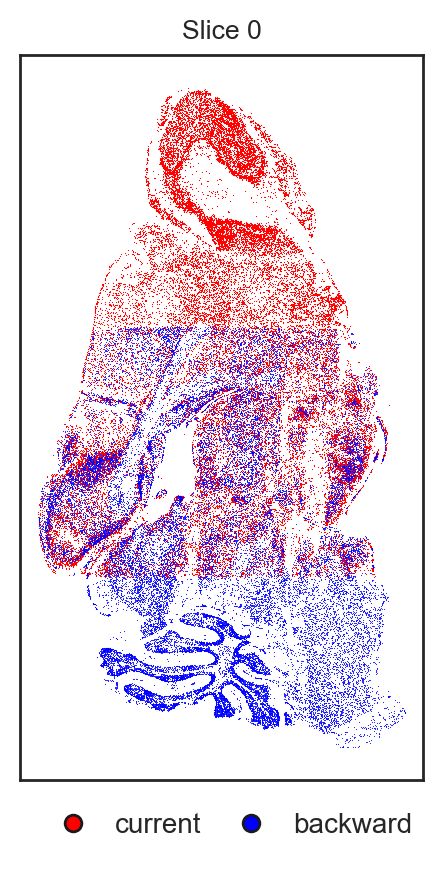

In [74]:
# Visualize the nonrigid alignment results
st.pl.overlay_slices_2d(slices = aligned_slices, spatial_key = key_added+'_nonrigid', height=5, overlay_type='backward')

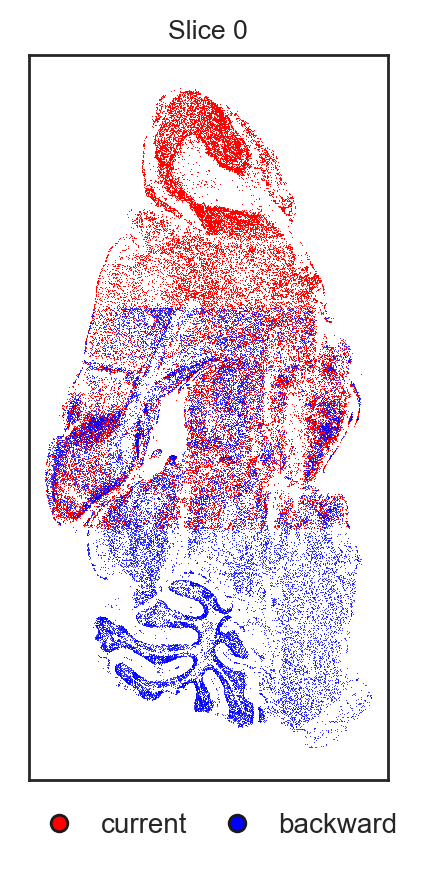

In [75]:
# Visualize the rigid alignment results
st.pl.overlay_slices_2d(slices = aligned_slices, spatial_key = key_added, height=5, overlay_type='backward')

Also let's try set nn_init to False

In [76]:
key_added = 'align_spatial'
spatial_key = 'spatial'
# spateo return aligned slices as well as the mapping matrix
aligned_slices, pis = st.align.morpho_align(
    models=[slice1, slice2],
    spatial_key=spatial_key,
    key_added=key_added,
    device=device,
    partial_robust_level=50,
    max_iter=500,
    rep_layer=['X_pca'],
    rep_field=['obsm'],
    dissimilarity=['cos'],
    nn_init=False,
    
)

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([16660.1055, 16660.1055])...
|-----------> Scale: tensor([[19145.3926, 25693.7109],
        [20163.9238, 49613.6914]], device='cuda:0')...
|-----> Preprocess finished.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [33.2849s]
|-----> Key Parameters: gamma: 0.5081432461738586; sigma2: 0.001910524326376617; probability_parameters: [tensor(0.0100, device='cuda:0')]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [0.4013s]


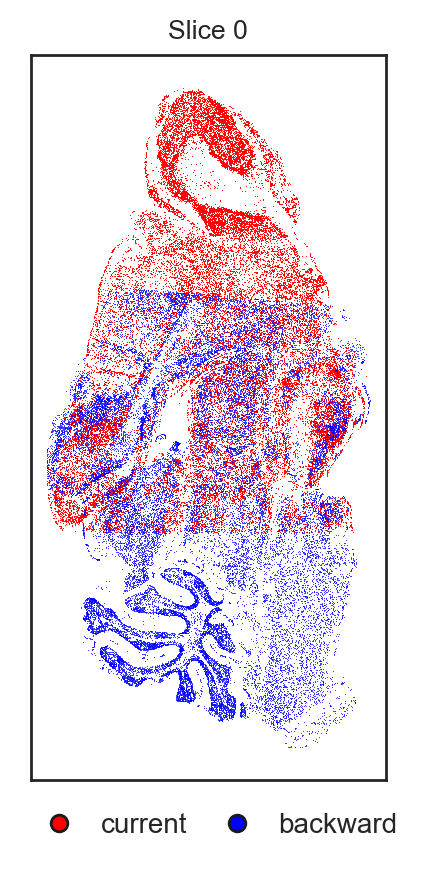

In [77]:
# Visualize the rigid alignment results
st.pl.overlay_slices_2d(slices = aligned_slices, spatial_key = key_added, height=5, overlay_type='backward')

## Conclusion

In this tutorial, we've demonstrated how to perform partial alignment using Spateo. Spateo can accurately, efficiently, and robustly align partially overlapping slices while identifying non-overlapping regions. We also explored key parameters that impact Spateo's partial alignment, such as `partial_robust_level`, `nn_init`, and nonrigid alignment parameters. Increasing `partial_robust_level` enhances robustness in partial alignment, while increasing the flexibility of nonrigid transformations can reduce alignment performance. It is recommended to always enable `nn_init` for optimal results.